# Projections

As the package allows to use most of the MoleculeKit projections (as long as the obtained matrix has more than one rows of features), we report here the ID values computed on different metrics, tested both on [villin](#villin) and [NTL9](#ntl9).

To highlight the structural features of the two proteins we selected the atomic distances (Cα, Cβ) and torsion angles (φ/ψ, χ) as test projections.

In [1]:
from md_intrinsic_dimension import intrinsic_dimension, section_id, secondary_structure_id
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import seaborn as sns
import logging
from moleculekit.molecule import Molecule 
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from itertools import product
from matplotlib.lines import Line2D

#build personalised cmap
colors = mpl.colors.ListedColormap(
    name="discrete-bicolor",
    colors=["#e9ff99","#ceff29", "#A5CC21", "#C099F3", "#6100e0", "#4E00B3"])
cmap = plt.get_cmap('jet')

#set font dimension
plt.rcParams.update({
	'axes.titlesize': 13,
	'axes.labelsize': 13,
	'xtick.labelsize': 11,
	'ytick.labelsize': 11,
	'legend.fontsize': 11,
	'legend.title_fontsize': 13,
	'lines.linewidth' : 1,
	'lines.markersize': 8,
})

## Villin

In [2]:
topology='examples/villin/2f4k.pdb'
trajectory='examples/villin/2f4k'
protein = 'villin'

data = []
states = ['u0','u1', 'u2', 'f0', 'f1', 'f2'] 

for state in states:
    mol = Molecule(topology)
    mol.read(trajectory+f'_{state}.xtc')
    mol.set('resname', 'LEU', 'resname NLE')
    mol.set('resname', 'HIS', 'resname HIP')
    mean_all, mean_last= intrinsic_dimension(mol=mol, projection_method='Distances', id_method='global', verbose=False)
    data.append({
            'trajectory': state,
            'projection': 'Cα Dist.',
            'mean_all': mean_all,
            'mean_last': mean_last,}) 
    mean_all, mean_last= intrinsic_dimension(mol=mol, projection_method='Distances', projection_kwargs={'step': 3}, id_method='global', verbose=False)
    data.append({
            'trajectory': state,
            'projection': 'Cα Dist. 3',
            'mean_all': mean_all,
            'mean_last': mean_last,}) 
    mean_all, mean_last= intrinsic_dimension(mol=mol, projection_method='Distances', projection_kwargs={'sele' : 'name CB'}, id_method='global', verbose=False)
    data.append({
            'trajectory': state,
            'projection': 'Cβ Dist.',
            'mean_all': mean_all,
            'mean_last': mean_last,}) 
    mean_all, mean_last= intrinsic_dimension(mol=mol, projection_method='Distances', projection_kwargs={'sele' : 'name CB','step': 3}, id_method='global', verbose=False)
    data.append({
            'trajectory': state,
            'projection': 'Cβ Dist. 3',
            'mean_all': mean_all,
            'mean_last': mean_last,})     
    mean_all, mean_last = intrinsic_dimension(mol=mol, projection_method='Dihedrals', id_method='global', verbose=False)
    data.append({
            'trajectory': state,
            'projection': "φ/ψ",
            'mean_all': mean_all,
            'mean_last': mean_last,}) 
    mean_all, mean_last = intrinsic_dimension(mol=mol, projection_method='Dihedrals', projection_kwargs = {'sincos':True},id_method='global', verbose=False)
    data.append({
            'trajectory': state,
            'projection': "Sin/Cos φ/ψ",
            'mean_all': mean_all,
            'mean_last': mean_last,}) 
    mean_all, mean_last = intrinsic_dimension(mol=mol, projection_method='Dihedrals', projection_kwargs = {'dihedrals': ('chi1', 'chi3', 'chi4', 'chi5')}, id_method='global', verbose=False)
    data.append({
            'trajectory': state,
            'projection': "χ",
            'mean_all': mean_all,
            'mean_last': mean_last,}) 
    mean_all, mean_last = intrinsic_dimension(mol=mol, projection_method='Dihedrals', projection_kwargs = {'dihedrals': ('chi1', 'chi3', 'chi4', 'chi5'),'sincos':True},id_method='global', verbose=False)
    data.append({
            'trajectory': state,
            'projection': "Sin/Cos χ",
            'mean_all': mean_all,
            'mean_last': mean_last,}) 
    
    
data = pd.DataFrame(data)
data["folded"] = data["trajectory"].str.startswith("f")

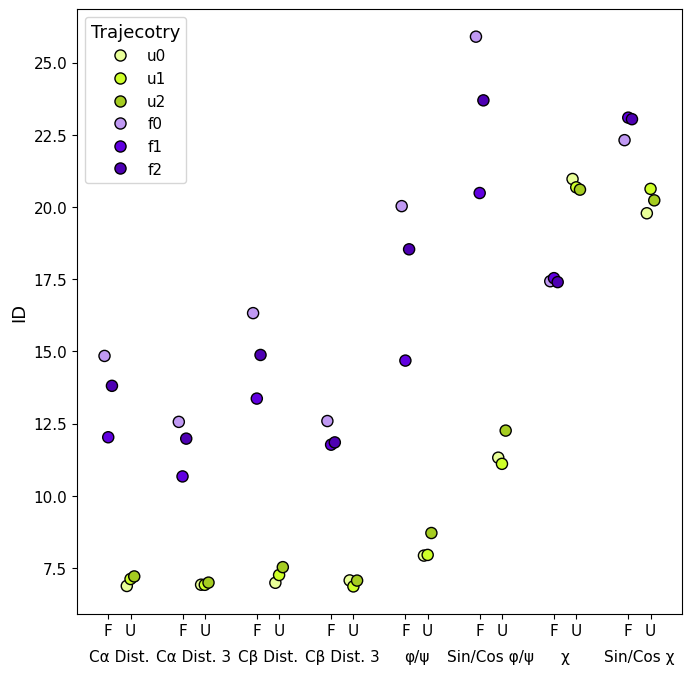

In [3]:
#prova
states = data["trajectory"].unique()
fig, ax = plt.subplots(figsize=(7,7))

projections = data['projection'].unique()
width = 0.3  # spacing between folded/unfolded

for i, proj in enumerate(projections):
    # Get all data for this projection first
    proj_data = data[data['projection'] == proj]
    total_points = len(proj_data)

    color_indices = np.arange(total_points) % colors.N
    proj_colors = [colors(ci) for ci in color_indices]

    folded_mask = proj_data['folded'].values
    proj_data = proj_data.copy()
    proj_data['color'] = proj_colors

    for folded, group in proj_data.groupby('folded'):
        y_vals = group['mean_all'].values
        group_colors = group['color'].values
        x_center = i
        x_shift = -width/2 if folded else width/2
        n_points = len(y_vals)
        jitter = np.linspace(-0.05, 0.05, n_points)
        x_vals = np.full_like(y_vals, x_center + x_shift) + jitter

        ax.scatter(x_vals, y_vals,color=group_colors,edgecolor='black', marker='o', s=64,label=f"{proj} - {'Folded' if folded else 'Unfolded'}")

x_ticks = []
x_tick_labels = []
for i in range(len(projections)):
    x_ticks += [i - width/2, i + width/2]
    x_tick_labels += ['F', 'U']
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)
ax.set_box_aspect(1)

sec = ax.secondary_xaxis(location=-0.05)
sec.tick_params('x', length=0)
sec.spines['bottom'].set_linewidth(0)
sec.set_xticks(range(len(projections)))
sec.set_xticklabels(projections)

color_map = {s: colors(i % colors.N) for i, s in enumerate(states)}
handles = [
    plt.Line2D(
        [0], [0], marker='o', color='w',
        markerfacecolor=color_map[s], markeredgecolor='black',
        markersize=8, label=s
    )
    for s in states
]
ax.legend(handles=handles, title="Trajecotry", loc='best')
ax.set_ylabel("ID")
plt.tight_layout()
#plt.savefig('../extra/villin_projections.pdf', dpi=300)
plt.show()


## NTL9

In [4]:
topology='examples/NTL9/ntl9.pdb'
trajectory='examples/NTL9/ntl9'
protein = 'NTL9'


data = []
states = ['u0','u1', 'u2', 'f0', 'f1', 'f2'] 

for state in states:
    mol = Molecule(topology)
    mol.read(trajectory+f'_{state}.xtc')
    mol.set('resname', 'LEU', 'resname NLE')
    mol.set('resname', 'HIS', 'resname HIP')
    mean_all, mean_last= intrinsic_dimension(mol=mol, projection_method='Distances', id_method='global', verbose=False)
    data.append({
            'trajectory': state,
            'projection': 'Cα Dist.',
            'mean_all': mean_all,
            'mean_last': mean_last,}) 
    mean_all, mean_last= intrinsic_dimension(mol=mol, projection_method='Distances', projection_kwargs={'step': 3}, id_method='global', verbose=False)
    data.append({
            'trajectory': state,
            'projection': 'Cα Dist. 3',
            'mean_all': mean_all,
            'mean_last': mean_last,}) 
    mean_all, mean_last= intrinsic_dimension(mol=mol, projection_method='Distances', projection_kwargs={'sele' : 'name CB'}, id_method='global', verbose=False)
    data.append({
            'trajectory': state,
            'projection': 'Cβ Dist.',
            'mean_all': mean_all,
            'mean_last': mean_last,}) 
    mean_all, mean_last= intrinsic_dimension(mol=mol, projection_method='Distances', projection_kwargs={'sele' : 'name CB','step': 3}, id_method='global', verbose=False)
    data.append({
            'trajectory': state,
            'projection': 'Cβ Dist. 3',
            'mean_all': mean_all,
            'mean_last': mean_last,})     
    mean_all, mean_last = intrinsic_dimension(mol=mol, projection_method='Dihedrals', id_method='global', verbose=False)
    data.append({
            'trajectory': state,
            'projection': "φ/ψ",
            'mean_all': mean_all,
            'mean_last': mean_last,}) 
    mean_all, mean_last = intrinsic_dimension(mol=mol, projection_method='Dihedrals', projection_kwargs = {'sincos':True},id_method='global', verbose=False)
    data.append({
            'trajectory': state,
            'projection': "Sin/Cos φ/ψ",
            'mean_all': mean_all,
            'mean_last': mean_last,}) 
    mean_all, mean_last = intrinsic_dimension(mol=mol, projection_method='Dihedrals', projection_kwargs = {'dihedrals': ('chi1', 'chi3', 'chi4', 'chi5')}, id_method='global', verbose=False)
    data.append({
            'trajectory': state,
            'projection': "χ",
            'mean_all': mean_all,
            'mean_last': mean_last,}) 
    mean_all, mean_last = intrinsic_dimension(mol=mol, projection_method='Dihedrals', projection_kwargs = {'dihedrals': ('chi1', 'chi3', 'chi4', 'chi5'),'sincos':True},id_method='global', verbose=False)
    data.append({
            'trajectory': state,
            'projection': "Sin/Cos χ",
            'mean_all': mean_all,
            'mean_last': mean_last,}) 
    
data = pd.DataFrame(data)
data["folded"] = data["trajectory"].str.startswith("f")

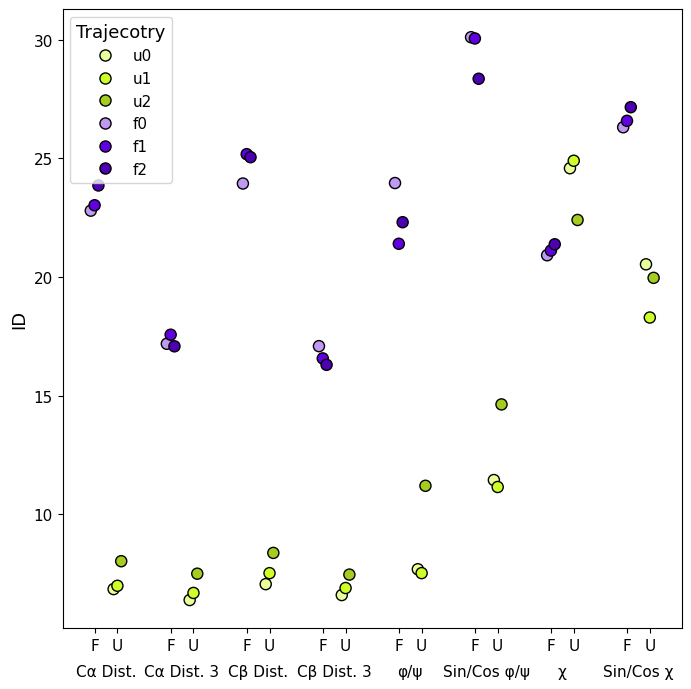

In [5]:
states = data["trajectory"].unique()
fig, ax = plt.subplots(figsize=(7,7))

projections = data['projection'].unique()
width = 0.3  # spacing between folded/unfolded

for i, proj in enumerate(projections):
    # Get all data for this projection first
    proj_data = data[data['projection'] == proj]
    total_points = len(proj_data)

    color_indices = np.arange(total_points) % colors.N
    proj_colors = [colors(ci) for ci in color_indices]

    folded_mask = proj_data['folded'].values
    proj_data = proj_data.copy()
    proj_data['color'] = proj_colors

    for folded, group in proj_data.groupby('folded'):
        y_vals = group['mean_all'].values
        group_colors = group['color'].values
        x_center = i
        x_shift = -width/2 if folded else width/2
        n_points = len(y_vals)
        jitter = np.linspace(-0.05, 0.05, n_points)
        x_vals = np.full_like(y_vals, x_center + x_shift) + jitter

        ax.scatter(x_vals, y_vals,color=group_colors,edgecolor='black', marker='o', s=64,label=f"{proj} - {'Folded' if folded else 'Unfolded'}")

x_ticks = []
x_tick_labels = []
for i in range(len(projections)):
    x_ticks += [i - width/2, i + width/2]
    x_tick_labels += ['F', 'U']
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)
ax.set_box_aspect(1)

sec = ax.secondary_xaxis(location=-0.05)
sec.tick_params('x', length=0)
sec.spines['bottom'].set_linewidth(0)
sec.set_xticks(range(len(projections)))
sec.set_xticklabels(projections)

color_map = {s: colors(i % colors.N) for i, s in enumerate(states)}
handles = [
    plt.Line2D(
        [0], [0], marker='o', color='w',
        markerfacecolor=color_map[s], markeredgecolor='black',
        markersize=8, label=s
    )
    for s in states
]
ax.legend(handles=handles, title="Trajecotry", loc='best')
ax.set_ylabel("ID")
plt.tight_layout()
#plt.savefig('../extra/NTL9_projections.pdf', dpi = 300)
plt.show()